In [41]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time

In [2]:
def portfolio_construct(returns, loan_cap, budget, size, risk_tol, prop_grad = None, method='highest'):
    '''
    :param returns: list of returns predicted
    :param loan_cap: maximum investment for each loan
    :param budget: money amount invested in the portfolio
    :param risk_tol: risk tolerance of the investor
    :param size: size of the portfolio
    :param method: 'highest' for highest returns, 'random' randomly pick loans 
    :return: list of weights of the portfolio and its return
    '''
    
    return_portfolios = []
    num_sample = 100
    
    start=time.time()
    
    print(f'Construction method : {method}')
    if method.lower() == 'random':
        portfolio = returns.sample(size)
        return_portfolio = portfolio.annualized_ret.mean()
    
        print(return_portfolio)
        for N in range(1000, 100000, 1000):
            tmp = []
            for i in range(num_sample):
                portfolio = returns.sample(N)
                tmp.append(portfolio.annualized_ret.mean())
                
            return_portfolios.append(np.mean(tmp))
            
        plt.plot(range(1000, 100000, 1000), return_portfolios, label='random')
        plt.xlabel('Size of portfolio')
        plt.ylabel('Return of portfolio(%)')
        plt.legend()
        
    elif method.lower() == 'highest':
        portfolio = returns.sort_values(by='annualized_ret', ascending=False).iloc[:size,]
        return_portfolio = portfolio.annualized_ret.mean()
        
        print(return_portfolio)
        for N in range(1000, 100000, 1000):
            portfolio = returns.sort_values(by='annualized_ret', ascending=False).iloc[:N,]
            return_portfolios.append(portfolio.annualized_ret.mean())
            
        plt.plot(range(1000, 100000, 1000), return_portfolios, label='highest')
        plt.xlabel('Size of portfolio')
        plt.ylabel('Return of portfolio(%)')
        plt.legend()
        
    else:
        raise ValueError(f'{method} is not a portfolio valid construction method.')
        
    print(f'Time : {time.time() - start}')

Construction method : random
0.11237893720190018
Time : 45.333877086639404
Construction method : highest
0.25211681463442553
Time : 2.8985788822174072


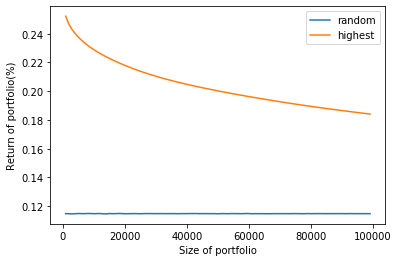

In [4]:
ret_def = pd.read_csv('./rawData/predicted_returns_defaulting.csv')
ret_notdef = pd.read_csv('./rawData/predicted_returns_non_defaulting.csv')

returns_loan = pd.concat([ret_def, ret_notdef])
loan_cap = np.repeat(10000, len(returns_loan))
budget = 1000000
size = 1000
risk_tol = .4

portfolio_construct(returns_loan, loan_cap, budget, size, risk_tol, method='random')
portfolio_construct(returns_loan, loan_cap, budget, size, risk_tol, method='highest')

In [36]:
def Portfolio_optimizer(returns, loan_cap, budget, size, risk_tol, prop_grad = None):
    '''
    :param returns: list of returns predicted
    :param loan_cap: maximum investment for each loan
    :param budget: money amount invested in the portfolio
    :param risk_tol: risk tolerance of the investor
    :param size: size of the portfolio
    :return: list of weights of the portfolio and its return
    '''
    # x: in {0,1}, 0 if not invest in loan i, 1 if invest in loan i
    # a: amount invested in loan i
    x = {}
    a = {}
        
    m = Model('maximizing_returns_with_constraints')
    
    for i in returns.shape[0]:
        x[i] = m.addVar(vtype=GRB.BINARY)
        
        # The amount invested in loan i is bounded by 0 and loan_cap[i] (if invested, ie x[i] = 1)
        a[i] = m.addVar(lb=0, ub=x[i]*loan_cap[i])
    
    # An investor can't invest more than his budget and wants to invest more than 90% of his capital
    m.addConstr(Budget >= quicksum(x[i]*a[i] for i in returns.shape[0]))
    m.addConstr(.9*Budget <= quicksum(x[i]*a[i] for i in returns.shape[0]))
    
    # The investor wants to invest in a certain amount of loans
    m.addConstr(size >= quicksum(x))
    m.addConstr(.95*size <= quicksum(x))
    
    # Risk tolerance constraint
#     m.addConstr(risk_tol == )

#     m.setObjective((quicksum(x[i]*(returns[i] - risk_tol*risk_loan[i])*a[i]
#                            for i in returns.shape[0]), GRB.MINIMIZE))

    m.setObjective((quicksum(x[i]*returns[i]*a[i]
                           for i in returns.shape[0]), GRB.MINIMIZE))
    
    m.optimize()
    
    return m

In [27]:
def Markowitz_portfolio(returns, loan_amount, inv_amount, size, risk_tol):
    '''
    :param returns: list of returns predicted, if default and if non default
    :param loan_amount: maximum investment for each loan
    :param inv_amount: money amount invested in the portfolio
    :param size: size of the portfolio
    :param risk_tol: risk tolerance of the investor
    :return: list of weights of the portfolio, returns
    '''

    n = len(returns)

    objective = lambda x: sum(x[0][i]*returns[i]*x[1][i] for i in returns.shape[0])
    
    # Can't invest more than what you have
    cst0 = lambda x: x[0][:]*(x[0][:]-1)
    cst1 = lambda x: size-sum(x[0][:])
    cst2 = lambda x: sum(x[0][:])-int(.9*size)
    cst3 = lambda x: inv_amount-sum(x[0][:]*x[1][:])

    # Can't invest more than the loan amount
    cst4 = lambda x: loan_amount-x[0][:]*x[1][:]

    # Risk tolerance constraint
    cst5 = lambda:1

    constraints = (
        {'type': 'eq', 'fun': cst0},
        {'type': 'ineq', 'fun': cst1},
        {'type': 'ineq', 'fun': cst2},
        {'type': 'ineq', 'fun': cst3},
        {'type': 'ineq', 'fun': cst4}
    )

    x0 = np.zeros(n)
    a0 = np.zeros(n)

    res = minimize(objective, x0=[x0, a0], method='SLSQP', constraints=constraints)

    # exp_port = res['x'].dot(returns_loan)
    # var_port = np.transpose(res['x']).dot(covarMat).dot(res['x'])

    # print(f'Expected return of the portfolio : {exp_port}')
    # print(f'Variance of the portfolio : {var_port}')

    # print(res)

In [28]:
ret_def = pd.read_csv('./rawData/predicted_returns_defaulting.csv')
ret_notdef = pd.read_csv('./rawData/predicted_returns_non_defaulting.csv')

returns_loan = pd.concat([ret_def, ret_notdef])
maxloan = np.repeat(10000, len(returns_loan))
budget = 1000000
size = 1000
risk_tol = .4

Markowitz_portfolio(returns_loan['annualized_ret'].iloc[:10000], maxloan, budget, size, risk_tol)

IndexError: invalid index to scalar variable.